In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
## load the data

full_df = pd.read_pickle("2010_data.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME', 'geometry'],axis=1)
pd.set_option('display.max_columns', None)
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,4.351195e-06,4.876012e-09,3.973694e-06,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,2.916594e-06,25.766945,25.620820,2.109251e-06,4.289945e-06,3.297524e-06,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,1.620365e-06
1,77.826608,286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,3.513297e-06,4.926652e-09,2.062545e-06,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,2.408668e-06,27.838995,27.701486,2.641386e-06,5.453165e-06,4.363785e-06,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,1.140217e-06
2,75.841973,284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,4.161191e-06,4.878442e-09,3.484876e-06,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,2.561723e-06,26.076443,25.936913,2.072566e-06,4.220296e-06,3.329836e-06,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,1.212712e-06
3,73.705432,283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,4.369584e-06,4.879895e-09,3.844808e-06,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,3.263775e-06,25.607194,25.458810,2.049331e-06,4.173433e-06,3.204589e-06,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,1.971961e-06
4,75.753407,282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,4.043741e-06,4.893173e-09,2.631260e-06,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,3.696579e-06,24.042930,23.889293,1.644247e-06,3.319324e-06,2.564080e-06,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,2.447597e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.842111,278.301219,0.004760,0.01800,0.004101,2.370862,0.499930,101630.449624,0.043633,7.253336e-09,1.103061e-08,0.005092,0.798388,288.873684,0.016426,0.023886,78530.596578,268.911264,0.081471,0.000644,0.000003,1.057299e-06,4.941603e-09,8.047194e-08,0.007655,0.000003,0.000002,4.937694e-07,0.006915,0.000005,5.093373e-07,1.734801e-06,7.928388,7.855770,5.407217e-07,1.250976e-06,3.762784e-06,9.304454e-08,0.000002,4.126463e-07,0.000008,2.043045e-07,0.000013,9.202822e-07,0.000003,1.312529e-06
3123,83.771012,267.887551,274.410086,0.004909,0.01800,0.001664,2.481296,2.428177,101634.772736,0.046080,6.861324e-09,9.790676e-09,0.006100,0.807739,305.402204,0.095034,0.021758,75497.845779,268.751272,0.080511,0.000615,0.000003,8.352510e-07,4.851321e-09,7.964809e-08,0.007339,0.000003,0.000001,2.701267e-07,0.007030,0.000004,4.969263e-07,5.508047e-07,6.659885,6.563536,2.826886e-07,6.105456e

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.53


In [5]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()


In [6]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')


RMSE scores for each fold: [1.52079425 1.4384173  1.44569455 1.4670836 ]
Mean RMSE score: 1.4679974236633162
Standard deviation of RMSE scores: 0.032251907780322164


In [7]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'n_estimators':[80,90,100,110,120,150], 'max_features': [6,8,10,12,15], 'max_depth':[100, 150, 200],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 270 candidates, totalling 1080 fits
CPU times: total: 38min 13s
Wall time: 6min 31s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200],
                          'max_features': [6, 8, 10, 12, 15],
                          'min_samples_split': [5, 10, 20],
                          'n_estimators': [80, 90, 100, 110, 120, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=150, max_features=15, min_samples_split=5,
                      n_estimators=120, n_jobs=-1, oob_score=True)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.64


In [11]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.64


In [12]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.40


In [13]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.93


In [15]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.61


In [16]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

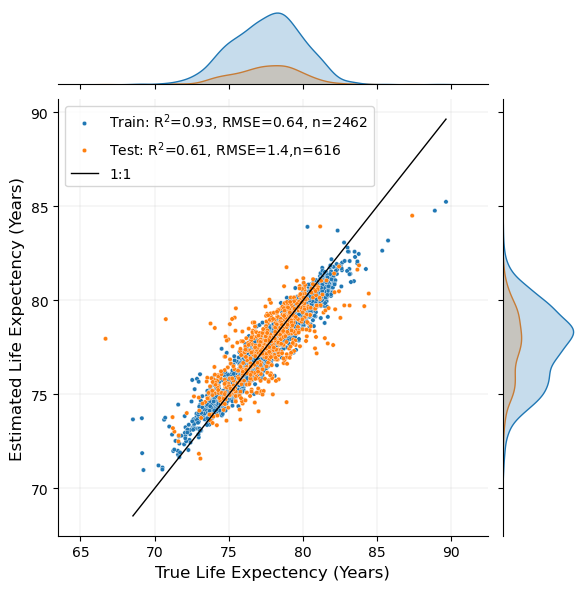

In [17]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  


g.ax_joint.legend(handles=handles,  labels=[ f'Train: R$^2$={corr_train}, RMSE={rmse_train}, n={len(X_train)}', 
                                             f'Test: R$^2$={corr_test}, RMSE={rmse_test},n={len(X_test)}','1:1'],
                                                                                                        title=None)

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

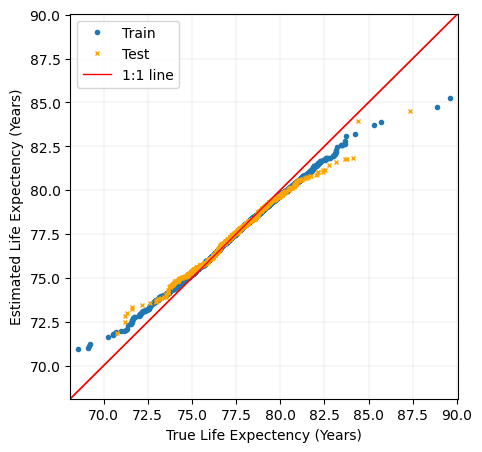

In [18]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()